# Grama: Fitting Functions

*Purpose*: Often, we will be able to write down a function (say, using physical laws) that maps input physical quantities to some output of interest. However, we may not have the means to *set values* for those physical inputs. Or, we might be using the model to *infer* values for some physical inputs (i.e. a measurement model). In this case, we can use statistical tools to *fit* the parameters in a function using a dataset. This exercise will introduce these ideas with a particular case study.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

# Fitting

Recall that there are four classes of verb in grama; *fitting* verbs take data as an input and produce a model as an output. There are various ways to fit a model; in this exercise we'll focus on fitting a *parameterized* model using  *nonlinear least squares*.



![Grama verb class diagram](./images/verb-classes.png)


## Trajectory Data

We're going to use the following trajectory dataset to fit a function predicting the trajectory. Our goal in this case study is as follows:

> Our goal is to fit a trajectory model and accurately predict the range of the projectile.

Note that our data only covers the beginning of the trajectory; we can't see where it lands (hence, we don't know its range).


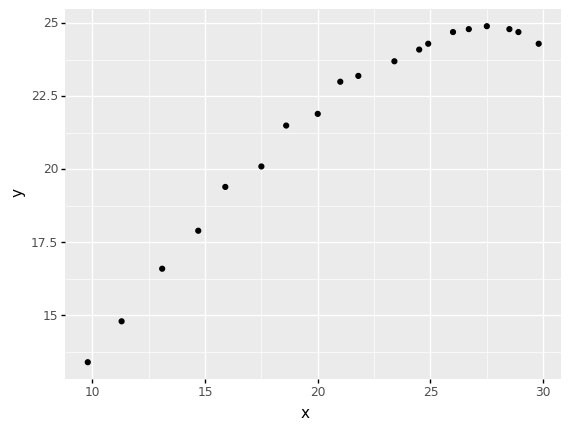

<ggplot: (8789009847730)>

In [2]:
# NOTE: No need to edit
from grama.data import df_trajectory_windowed
(
    df_trajectory_windowed
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_point()
)

# EMA of Proposed Model

Before we jump immediately to using statistical procedures to fit a function, let's first use EMA to understand the model we're going to fit.


## Trajectory model

The following code loads a model for the trajectory of a projectile subject to a *linear drag force*.


In [3]:
from grama.models import make_trajectory_linear
md_trajectory = make_trajectory_linear()
md_trajectory

model: Trajectory Model

  inputs:
    var_det:
      u0: [0.1, inf]
      tau: [0.05, inf]
      t: [0, 600]
      v0: [0.1, inf]

    var_rand:

    copula:
      None

  functions:
      x_trajectory: ['u0', 'v0', 'tau', 't'] -> ['x']
      y_trajectory: ['u0', 'v0', 'tau', 't'] -> ['y']

### Linear drag model

The drag $\vec{F}_d$ acting on the projectile in this model has a magnitude equal to

$$F_d \propto - m \tau s$$

where $m$ is the mass of the projectile, $s$ is its speed, and $\tau$ is the *time constant* associated with the drag law.

We can make sense of the model by inspecting the equations in the model. However, a complementary way to gain understanding is to do a little *exploratory model analysis*. You'll use EMA below to understand the model's behavior.


## Sinews and bounds

One "gotcha" with `ev_sinews()` is that it can only sweep inputs with *finite bounds*. For variables with one-sided bounds, such as `[0.1, inf]`, we cannot sweep values all the way to infinity! Instead, grama will set the inputs with one-sided bounds to their lower bound, and sweep the remaining variables. We need to set finite bounds in order to use `gr.ev_sinews()`.


### __q1__ Sweep values of `tau`

Update the model to enable a sweep over values of `tau`. How does changing `tau` affect the trajectory? Answer the questions under *observations* below.

*Hint*: Remember that `gr.cp_bounds()` allows you to adjust the bounds of a grama model. Note that you may need to adjust the bounds of time `t` as well as `tau` to make an informative plot.


Calling plot_sinew_outputs....


/Users/zach/opt/anaconda3/envs/evc/lib/python3.9/site-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


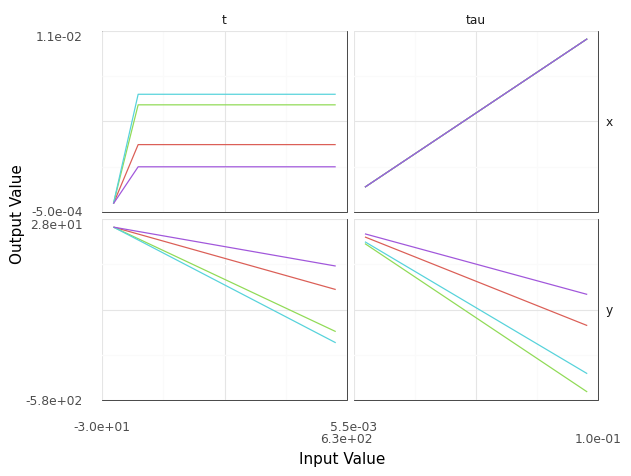

<ggplot: (8788972083167)>

In [4]:
(
    md_trajectory
    >> gr.cp_bounds(tau=[0.01, 0.1])
    >> gr.ev_sinews(df_det="swp", n_sweeps=4)
    >> gr.pt_auto()
)

*Observations*

- Once you get a sweep of `tau` displayed, what do each of the curves in the `tau` column represent?
  - Each curve in the `tau` column represents the effect `tau` has on the relevant output (`x` or `y`) *at a fixed point in time `t`*.
- What affect does `tau` have on the trajectory range `x` at a fixed point in time `t`?
  - Increasing `tau` tends to increase the range at a fixed point in time.
- What affect does `tau` have on the trajectory height `y` at a fixed point in time `t`?
  - Increasing `tau` tends to decrease the height at a fixed point in time.


### __q2__ Plot a few trajectories

Complete the code below to sweep over values of `tau` and `t`. Compare these results with what you found above. Answer the questions under *observations* below.


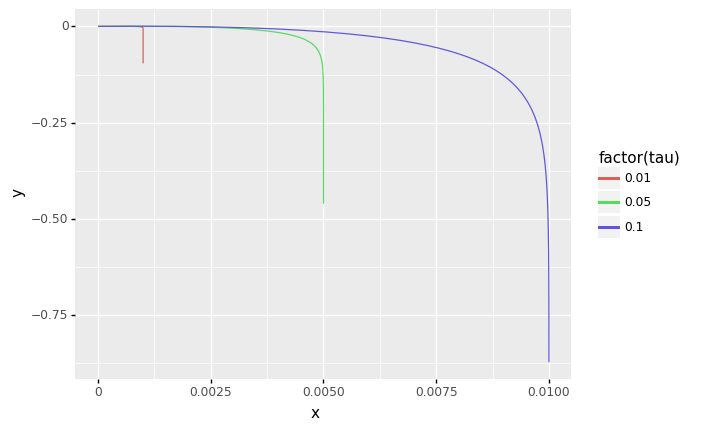

<ggplot: (8789009954823)>

In [5]:
# TASK: Sweep tau and t to create trajectories
(
    md_trajectory
    >> gr.ev_df(
        df=gr.df_grid(
            u0=0.1,
            v0=0.1,

            tau=[0.01, 0.05, 0.1],
            t=gr.linspace(0, 1, 100)
        )
    )
    >> gr.ggplot(gr.aes("x", "y", color="factor(tau)"))
    + gr.geom_line()
)

*Observations*

- What affect does `tau` have on the trajectory?
  - Increasing `tau` tends to extend the trajectory, allowing the projectile to reach longer distances.
- Imagine that `y == 0` represents the ground. Are the endpoints of these trajectories physically reasonable?
  - No; the endpoints are below the ground.


# Fitting with Least Squares

Above, we used EMA to make sense of the model's behavior, but we only guessed at parameter values. Now let's use a statistical fitting procedure to get reasonable values for the inputs.


## The `ft_nls()` routine

The `gr.ft_nls()` routine is a *fitting* routine; it takes in a dataset and returns a (fitted) model. NLS stands for [*nonlinear least squares*](https://en.wikipedia.org/wiki/Non-linear_least_squares), a general-purpose way to fit a parameterized function to a dataset. There is a great deal of statistical theory underpinning NLS, which we will not cover in this exercise. The short version is: NLS seeks input (parameter) values of a function that give the best "agreement" between the function's output and measured output values.

There are a number of practical concerns to using NLS effectively, which we'll study below.


### __q3__ Run `ft_nls()`

Use `gr.ft_nls()` to fit the model `md_trajectory` to the data `df_trajectory_windowed`. Answer the questions under *observations* below.

*Hint*: Make sure to read the documentation of an unfamiliar function to learn how to use it!


In [6]:
# TASK: Fit a model to the data
md_fit = (
    df_trajectory_windowed

    >> gr.ft_nls(md=md_trajectory)
)

## NOTE: Use this to check your work
assert \
    isinstance(md_fit, gr.Model), \
    "md_fit is not a model; make sure to fit a model"

md_fit

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
           u0   tau          v0  u0_0  tau_0  v0_0  success  \
0  425.161431  0.05  447.996569   0.1   0.05   0.1     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       3  25.49725  


model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['t'] -> ['u0', 'tau', 'v0']
      Trajectory Model: ['u0', 't', 'tau', 'v0'] -> ['y', 'x']

*Observations*

- The `gr.ft_nls()` routine should print some diagnostic information; was the optimizer `success`ful in finding best-fit input values? How do you know?
  - According to the diagnostics, yes. The `success` column indicates `True`.
- The `gr.ft_nls()` starts from an "initial guess" for each of the inputs; these are shown in the diagnostic information as the input names with the suffix `_0`. What were the initial guess values for the inputs?
  - `tau_0=0.05, u0_0=0.1, v0_0=0.1`
<!-- solution-end -->

The fitting diagnostics only tell us so much; it is a far better idea to compare predictions from the model directly against the original data.


### __q4__ Assess the fit

Evaluate the fitted model `md_fit` to compare the predicted values against the original dataset. Answer the questions under *observations* below.


... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


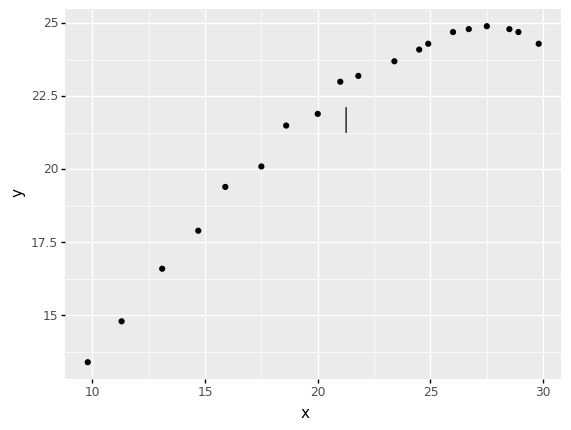

<ggplot: (8788972445868)>

In [7]:
# TASK: Compare the model predictions with
# the original data df_trajectory_windowed
(
    md_fit

    >> gr.ev_df(df_trajectory_windowed)
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

*Observations*

- How well does the fitted model (solid line) agree with the measured values (dots)?
  - Terrible! The fitted model somehow gives a small vertical segment in the middle of the plot. This looks nothing like the measured values!


## Rough estimation

Clearly, using completely-arbitrary guesses for the initial parameter values has led to a terrible fit. Let's do some back-of-the envelope calculations to get a rough sense of reasonable parameter values.

The horizontal velocity is the time-derivative of horizontal position; we can approximate this with a simple finite-difference

$$u = \frac{dx}{dt} \approx \frac{u(t_2) - u(t_1)}{t_2 - t_1}$$

The `gr.lead()` function allows us to access values in the following row; we can use this to implement differences like $u(t_2) - u(t_1)$. In code, this would be `gr.lead(DF.u) - DF.u`.

We can estimate the velocity of the projectile directly using the position and time data, but we'll have to work a little harder to estimate a reasonable value for `tau`. To do this, let's turn to the drag law: 

$$F_d \propto - m \tau s$$

Re-arranging to isolate $\tau$, we find

$$F_d/m/s \propto - \tau$$

or

$$|a_d / s| \propto |\tau|$$

where $a_d$ is the acceleration due to drag. Note that this is *not* the total acceleration! This is just the acceleration due to drag, which we can't access from the data alone. However, we can use the *total* acceleration to set a reasonable first-guess for the value of `tau`.

The following code implements the calculations described above and computes summary statistics over the estimated `u, v, tau` values.


In [8]:
# NOTE: No need to edit
(
    df_trajectory_windowed
    # Estimate velocity components
    >> gr.tf_mutate(
        u=(gr.lead(DF.x) - DF.x) / (gr.lead(DF.t) - DF.t),
        v=(gr.lead(DF.y) - DF.y) / (gr.lead(DF.t) - DF.t),
    )
    # Compute speed
    >> gr.tf_mutate(s=gr.sqrt(DF.u**2 + DF.v**2))
    # Estimate acceleration
    >> gr.tf_mutate(
        a=(gr.lead(DF.s) - DF.s) / (gr.lead(DF.t) - DF.t)
    )
    # Estimate drag time constant
    >> gr.tf_mutate(tau=gr.abs(DF.a / DF.s))
    
    >> gr.tf_select("u", "v", "tau")
    >> gr.tf_describe()
)

,u,v,tau
count,18.000000,18.000000,17.000000
mean,11.111111,6.055556,4.463891
std,4.114378,6.512181,4.756788
min,4.000000,-4.000000,0.194824
25%,8.250000,1.250000,1.401754
50%,11.000000,4.000000,2.465337
75%,14.750000,12.500000,5.897357
max,18.000000,18.000000,16.172505


This *does not* directly provide the "best" parameter values for `u, v, tau`. However, this gets us in the right *ballpark*. Choosing values similar to the above will be much more effective than picking completely-arbitrary initial guess values.


### __q5__ Choose reasonable initial parameters

Override the default initial parameter guess of `ft_nls()` by adding a keyword argument. Using the rough estimates above, you should be able to achieve a fit of the data that is quite reasonable. Answer the questions under *observations* below.

*Hint*: Remember to consult the documentation for `ft_nls()` to see how to use its arguments!


... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
          u0       tau         v0  u0_0  tau_0  v0_0  success  \
0  18.792122  2.802267  28.234775    18     16    18     True   

                                           message  n_iter       mse  
0  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH      25  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


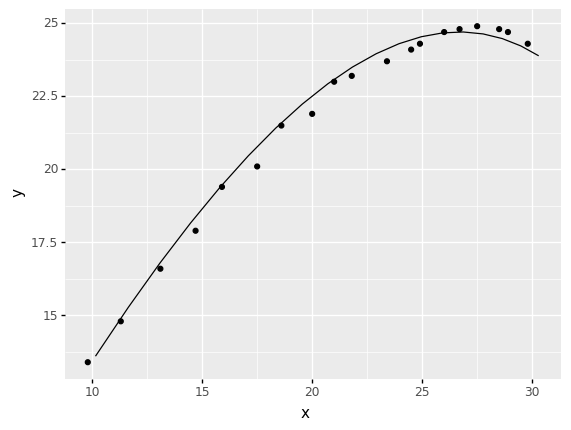

<ggplot: (8788988651201)>

In [9]:
# TASK: Set a reasonable initial guess for the input values
md_fit_init = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        df_init=gr.df_make(
            u0=18,
            v0=18,
            tau=16,
        )
    )
)

## NOTE: Use this to check your work
(
    md_fit_init
    >> gr.ev_df(df_trajectory_windowed)
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line()
    + gr.geom_point(data=df_trajectory_windowed)
)

*Observations*

- How well does the trend fit the data? Is the fit *perfect*?
  - Quite well! Certainly much better than the previous attempt. The fit is not perfect though; there seems to be some "jitter" in the measured values.
- How does your initial guess for `tau` compare with the fitted value? What might account for this?
  - My initial guess of `tau == 16` is quite a bit larger than the fitted value of `tau ~= 2.8`. As noted above, we estimated a time constant from the total acceleration, rather than the acceleration solely due to drag.
- How does your initial guess for `u0` compare with the fitted value? What might account for this?
  - My initial guess of `u0 == 18` is quite close to the fitted value of `u0 ~= 18.79`. The fitted value is larger, which makes intuitive sense (drag should slow the projectile), though it's closer than I might have expected.


# Model Assessment

We have successfully fit a function to data! However, before we start using this model to make predictions, we should carry out some *model assessment* studies to check that this is a reasonable model. The next few tasks will guide you through some useful assessment techniques.


## Quantifying uncertainty

The `gr.ft_nls()` routine allows us to quantify the uncertainty in the fitted values by fitting a joint distribution for the inputs. As we saw above, the fit of the function to the data is *not* perfect; therefore, the noise in the measured values implies we cannot estimate the input values perfectly. Setting `uq_method="linpool"` in `gr.ft_nls()` accounts for this by finding a "best-fit" value, but additionally fitting a normal distribution to account for the noise in the outputs.


In [10]:
# NOTE: No need to edit
md_fit_uq = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        df_init=gr.df_make(
            u0=18,
            v0=18,
            tau=16,
        ),
        ## NOTE: This fits a distribution for the inputs
        uq_method="linpool",
    )
)
md_fit_uq 

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = {'t'}
          u0       tau         v0  u0_0  tau_0  v0_0  success  \
0  18.792122  2.802267  28.234775    18     16    18     True   

                                           message  n_iter       mse  
0  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH      25  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


/Users/zach/Git/py_grama/grama/fit_synonyms.py:152: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


model: Trajectory Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)

    var_rand:
      u0: (+0) norm, {'mean': '1.879e+01', 's.d.': '1.700e-01', 'COV': 0.01, 'skew.': 0.0, 'kurt.': 3.0}
      tau: (+0) norm, {'mean': '2.800e+00', 's.d.': '1.300e-01', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}
      v0: (+0) norm, {'mean': '2.823e+01', 's.d.': '2.000e-01', 'COV': 0.01, 'skew.': 0.0, 'kurt.': 3.0}

    copula:
      Gaussian copula with correlations:
  var1 var2      corr
0   u0  tau -0.678984
1   u0   v0  0.000000
2  tau   v0 -0.704758

  functions:
      Trajectory Model: ['u0', 't', 'tau', 'v0'] -> ['y', 'x']

Since this is a grama model, we can use the same kind of sampling tools we've seen before to inspect the uncertainty in the fitted input values.


### __q6__ Inspect plausible input values

The following code visualizes the input uncertainty of the fitted values. Run the code below, and answer the questions under *observations* below.


eval_sample() is rounding n...
Design runtime estimates unavailable; model has no timing data.
Calling plot_scattermat....


/Users/zach/Git/py_grama/grama/plot_auto.py:234: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


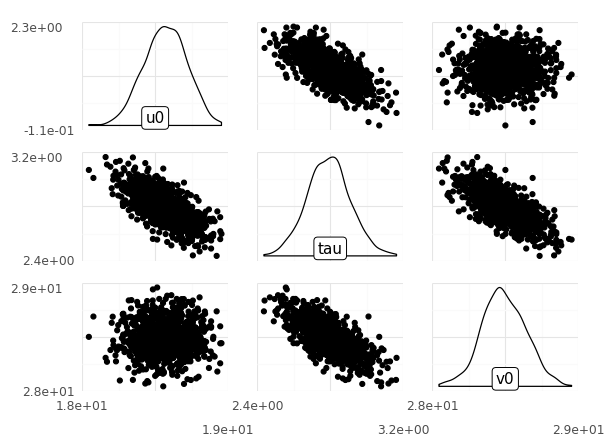

In [11]:
# TASK: Run and inspect
(
    md_fit_uq
    >> gr.ev_sample(n=1e3, df_det="nom", skip=True)
    >> gr.pt_auto()
)

*Observations*

- How variable are each of the inputs?
  - None of the inputs seem that variable; `tau` ranges between `2.2` and `3.3`, `u0` between `18` and `19`, and `v0` between `27` and `29`.
<!-- solution-end -->

### __q7__ Inspect plausible trajectories

Draw a random sample of trajectories to study the uncertainty in in the outputs. Make sure to pick a reasonable range of time values `t` so that you can see both the beginning and end (ground-strike at `y==0`) of the trajectory. Answer the questions under *observations* below.


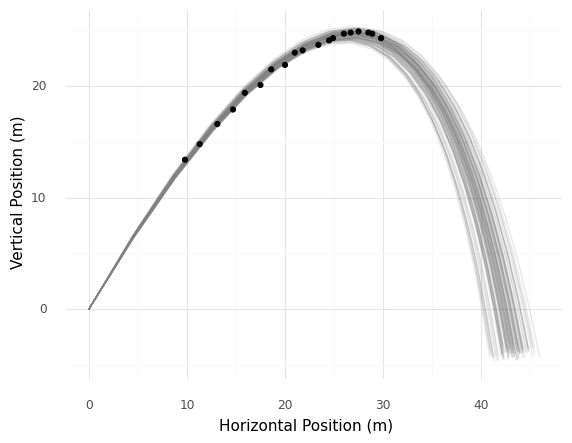

<ggplot: (8788988482241)>

In [12]:
# TASK: Evaluate the model
(
    md_fit_uq

    >> gr.ev_sample(
        n=100, 
        df_det=gr.df_make(t=gr.linspace(0, 4.8, 20))
    )
    
    ## NOTE: No need to edit below here; this will visualize your results
    >> gr.ggplot(gr.aes("x", "y"))
    # NOTE: The `group` aesthetic allows us to draw
    # individual lines for each value of u0; otherwise
    # the lines would all be connected
    + gr.geom_line(gr.aes(group="u0"), alpha=1/5, color="grey")
    # Add the data
    + gr.geom_point(data=df_trajectory_windowed)
    # Clean up the visual
    + gr.theme_minimal()
    + gr.labs(
        x="Horizontal Position (m)",
        y="Vertical Position (m)",
    )
)

*Observations*

- Compare the ensemble of trajectories (grey lines) against the measured values (black dots); is the uncertainty in the trajectory comparable to the observed variability in the measured values? How do you know?
  - Yes; the ensemble of trajectories covers a similar "width" as the measured values.
- According to the fitted model, what is a plausible final range for the projectile? (In what band of `x` values does it hit the ground at `y == 0`?)
  - The trajectories in the plot range from around `x_range == 40` to `x_range = 45`.


## Model Validation

One of the *most important* assessments we should carry out is *model validation*. When validating a model, we use a dataset that was *not* used to fit the model in order to check how well the model agrees with physical reality. This is to help avoid the statistical phenomenon of [overfitting](https://en.wikipedia.org/wiki/Overfitting).


## Validation data

Let's load a dataset that is appropriate for validation; the following data is from the same trajectory as `df_trajectory_windowed`, but it consists of independent observations, and it runs for a longer span of time values.


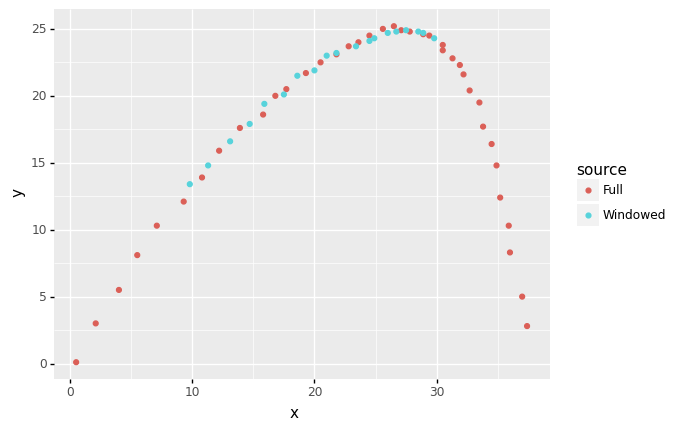

<ggplot: (8788954606201)>

In [13]:
## NOTE: No need to edit
from grama.data import df_trajectory_full
(
    df_trajectory_full
    >> gr.tf_mutate(source="Full")
    >> gr.tf_bind_rows(
        df_trajectory_windowed
        >> gr.tf_mutate(source="Windowed")
    )
    >> gr.ggplot(gr.aes("x", "y", color="source"))
    + gr.geom_point()
)

### __q8__ Compare the fit to validation data

Compare the predictions from the fitted model `md_fit_uq` to compare an ensemble of trajectories against the validation data `df_trajectory_full`. Answer the questions under *observations* below.

*Hint*: This part has no starter code! Use what you learned above to carry out this comparison.


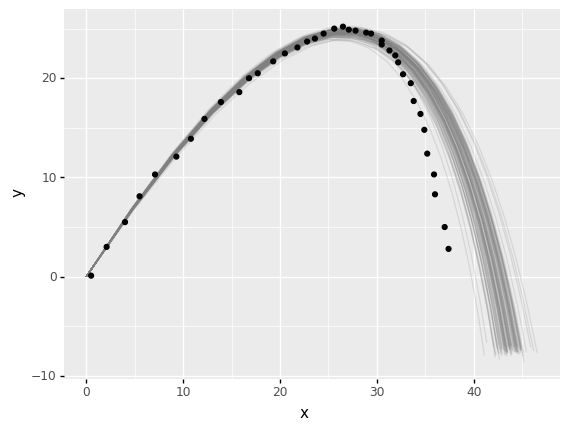

<ggplot: (8788972613545)>

In [14]:
# TASK: Compare the fitted model to the validation data;
# make sure to quantify the parameter uncertainty
(
    md_fit_uq
# solution-begin 
    >> gr.ev_sample(
        n=100, 
        df_det=gr.df_make(t=gr.linspace(0, 5, 20))
    )
    
    >> gr.ggplot(gr.aes("x", "y"))
    + gr.geom_line(gr.aes(group="u0"), alpha=1/5, color="grey")
    + gr.geom_point(data=df_trajectory_full)
# solution-end 
)

*Observations*

- How well does the model fit the data? Does the model perform better in some regions than others?
  - The model fits well at the beginning of the trajectory, but does progressively worse further into the trajectory. Towards the end, the model overpredicts the range by quite a bit! (A few meters.)


## The dramatic reveal...

It turns out the model does *not* accurately predict the trajectory's range! This is because our model assumes a *linear* drag law $F_d \propto - m \tau s$, while in reality the data were generated using a *quadratic* drag law $F_d \propto - m b s^2$. This qualitative difference between the model and the data-generating process leads to a mismatch between predicted and measured values that we can't overcome without changing the model's *form*.

This is why validation is so important: It is difficult to discover this kind of *model form error* without a validation study. In practice, data scientists will use a [*train-validation split*](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets) to help construct this sort of validation study.


# Further Reading

- This exercise is [based on a chapter](https://zdelrosario.github.io/uq-book-preview/02_diagnosing/model-form-error.html) from a forthcoming book I'm writing. You can see that draft chapter for more details on this case study.
- My most-highly recommended book for a deeper treatment of the train-validation split (and related ideas) is "An Introduction to Statistical Learning," which is [freely available online](https://www.statlearning.com/).
